# Assignment 3: Fine tuning a multiclass classification BERT model

**Description:** This assignment covers fine-tuning of a multiclass classification. You will compare two different types of solutions using BERT-based models. You should also be able to develop an intuition for:


* Working with BERT
* Using multiple models to focus on different sub-tasks
* Different metrics to measure the effectiveness of your model
* Modifying your models to deal with class imbalance



The assignment notebook closely follows the lesson notebooks. We will use the 20 newsgroups dataset and will leverage some of the models, or part of the code, for our current investigation.

**You are strongly encouraged to read through the entire notebook before answering any questions or writing any code.**

The initial part of the notebook is purely setup. We will then generate our BERT model and see if and how we can improve it.

Do not try to run this entire notebook on your GCP instance as the training of models requires a GPU to work in a timely fashion. This notebook should be run on a Google Colab leveraging a GPU. By default, when you open the notebook in Colab it will try to use a GPU. Total runtime of the entire notebook (with solutions and a Colab GPU) should be about 1h.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2023-fall-main/blob/master/assignment/a3/Multiclass_text_classification.ipynb)

The overall assignment structure is as follows:

1. Setup

  1.1 Libraries & Helper Functions

  1.2 Data Acquisition

  1.3 Training/Test/Validation Sets for BERT-based models

2. Classification with a fine tuned BERT model

  2.1 Create the specified BERT model

  2.2 Fine tune the BERT model as directed

  2.3 Examine the predictions with various metrics

3. Classification using two stages

  3.1 Relabel the data to group the often confused classes

  3.2 Train the first stage model on the relabeled data

  3.3 Separate the data for just the confused classes

  3.4 Train the second stage model on the two classes

  3.5 Combine and evaluate the predictions from the two stages

4. Look at examples of misclassifications, see what might have changed



**INSTRUCTIONS:**:

* Questions are always indicated as **QUESTION:**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1 and a2.

* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 1 in bulk. This is setup work and no questions are in there. At the end of section 1 we will state all of the relevant variables that were defined and created in section 1.

* **IMPORTANT NOTE:** Because the data we're using is downloaded each time we run section 1, a different split of train, validation, and test records is created.  This means that the accuracy, precision, recall, and F1 scores will change, although the delta will be small.  Please enter the values from your final run so that the answer values in your answers file correspond to the answer values in the outputs in your notebook.


### 1. Setup

Lets get all our libraries and download and process our data.

In [1]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.6 MB/s eta 0:00:00


In [2]:
!pip install pydot

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

In [5]:
from transformers import BertTokenizer, TFBertModel

We're going to use the 20 newsgroups dataset as it is ideal for exploring multiclass classification.  It includes posts from 20 different newsgroups.  Our task will be to correctly label a post with it's group.  We'll download the version available from sklearn.

In [6]:
def read_20newsgroups(test_size=0.1):
  # download & load 20newsgroups dataset from sklearn's repos
  dataset = fetch_20newsgroups(subset="all", shuffle=True, remove=("headers", "footers", "quotes"))
  documents = dataset.data
  labels = dataset.target
  # split into training & testing a return data as well as label names
  return train_test_split(documents, labels, test_size=test_size), dataset.target_names

# call the function
(train_texts, test_texts, train_labels, test_labels), target_names = read_20newsgroups()

Take a look at the records.  We basically have a long string of text and an associated label.  That label is the Usenet group where the posting occured. The records are the raw text.  They vary significantly in size.

In [7]:
train_texts[:2]

['\n\nYou are correct!  The motherboard manufacturer where I usually buy boards says\nthat they will have this problem fixed in about two weeks...',
 "Why do you insist on reposting the entire original post?\nDon't waste bandwidth, please.  You know how picky us non-\nJews can be.  Ha Ha. :|\n\n"]

Notice the "labels" are just integers that are an offset into the list of target names.

In [ ]:
train_labels[:2]
#Not in a format of one-hot-encoding

array([17,  2])

In [ ]:
train_labels.shape

(16000,)

The variable ''target_names'' stores all of the names of the labels.

In [ ]:
print(target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


We already have a test set and a train set.  Let's explicitly set aside part of our training set for validation purposes.

In [8]:
#len(train_texts)
valid_texts = train_texts[16000:]
valid_labels = train_labels[16000:]
train_texts = train_texts[:16000]
train_labels = train_labels[:16000]

The validation set will always have 961 records.

In [ ]:
len(valid_texts)

961

The training set will always have 16000 records.

In [ ]:
len(train_texts)

16000

**NOTE:** Each time you rerun the data you will draw a *DIFFERENT* set of train and test documents even though the numbers 961 and 16000 will always be the same.

In [9]:
#get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)

Here are the variables we've already defined for the data:

* train_texts - an array of text strings for training
* test_texts - an array of text strings for testing
* valid texts - an array of text strings for validation
* train_labels - an array of integers representing the labels associated with train_texts
* test_labels - an array of integers representing the labels associated with test_texts
* valid_labels - an array of integers representing the labels associated with valid_texts
* target_names - an array of label strings that correspond to the integers in the *_labels arrays

### 2. Classification with a fine tuned BERT model

Let's pick our BERT model.  We'll start with the base BERT model and we'll use the cased version since our data has capital and lower case letters.

In [10]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'

In [11]:
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

We're setting our maximum training record length to 200.  BERT models can handle more and after you've completed the assignment you're welcome to try larger and small sized records.

In [12]:
max_length = 200

Now we'll tokenize our three data slices.  This will take a minute or two.

In [13]:
# tokenize the dataset, truncate at `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
train_encodings.input_ids.shape

TensorShape([16000, 200])

In [ ]:
train_encodings.attention_mask.shape

TensorShape([16000, 200])

In [ ]:
train_encodings.token_type_ids.shape

TensorShape([16000, 200])

In [ ]:
train_texts[4:5]

["After reading this story about St. Maria Goretti (posted two weeks\nago), I am a bit confused.  While it is clear that her daily\nlife is one of probity and sanctity, I am afraid I don't quite\nunderstand the final episode of her life.  I am reading it \ncorrectly, she (and the Church apparently) felt that being raped\nwas a sin on _her_ part, one so perfidious that she would rather\ndie than commit it.  If this is the case I'm afraid that I \ndisagree rather strongly.\n\nCan anyone out there explain this one to me?\n\nYours in Christ,"]

Notice our input_ids for the first training record and their padding. The train_encodings also includes an array of token_type_ids and an attention_mask array.

In [ ]:
train_encodings.input_ids[:1]
#[CLS]:101
#[SEP]:102

<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[ 101, 2421, 1143, 2330, 6120, 1828,  119, 4229,  132,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [ ]:
train_encodings.attention_mask[:1]

<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]], dtype=int32)>

In [ ]:
#[SEP]
train_encodings.token_type_ids[4:5]

<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]], dtype=int32)>

Write a function to create this multiclass bert model.

Keep in mind the following:
* Each record can have one of n labels where n = the size of target_names.
* We'll still want a hidden size layer of size 201
* We'll want our hidden layer to make use of the **pooler output** from BERT
* We'll also want to use dropout
* Our classification layer will need to be appropriately sized and use the correct non-linearity for a multi-class problem.
* Since we have multiple labels we can no longer use binary cross entropy.  Instead we need to change our loss metric to a categorical cross entropy.  Which of the two categorical cross entropy metrics will work best here?
* Make sure that training affects **all** of the layers in BERT.


In [14]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 20,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    ### YOUR CODE HERE

    #training affects all of the layers in BERT
    bert_model.trainable = True

    #input layer of BERT, input size from (200,1) to (200,)
    input_ids = Input(shape=(200,), dtype='int32')
    attention_mask = Input(shape=(200,), dtype='int32')
    token_type_ids = Input(shape=(200,), dtype='int32')

    #build the model, from bottom to top: input sentences / tokenizer / BERT / [CLS] of BERT / Fully connected network with dropout to do the multiclassification task
    #intput of BERT: [train_encodings.input_ids, train_encodings.attention_mask]
    #[CLS]: pooler_output = bert_output[:, 0, :] ([batch, sequence index, embedding dimensions])
    bert_output = bert_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooler_output = bert_output.pooler_output

    # Add hidden layer / Dropout layer / softmax layer
    # input size from BERT (, 768)
    hidden_layer = Dense(hidden_size, activation='relu')(pooler_output)
    dropout_layer = Dropout(dropout)(hidden_layer)
    classification_layer = Dense(num_classes, activation='softmax')(dropout_layer)

     # Create and compile the model
    classification_model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=classification_layer)
    classification_model.compile(optimizer=Adam(learning_rate=learning_rate),
                                 loss=CategoricalCrossentropy(),
                                 metrics=['accuracy'])

    ### END YOUR CODE
    return classification_model

In [15]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=20)

In [16]:
pooler_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   72         'input_2[0][0]',         

**QUESTION:** 2.1 How many trainable parameters are in your dense hidden layer?
154569 (768*201 + 201)

**QUESTION:** 2.2 How many trainable parameters are in your classification layer?
4040 (201*20 + 20)

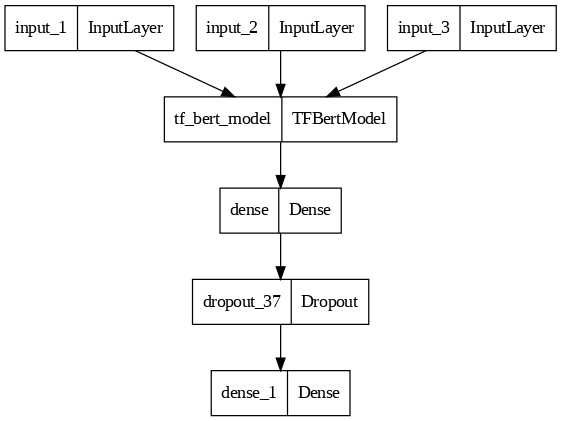

In [17]:
keras.utils.plot_model(pooler_bert_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [18]:
#Get the format of labels to one-hot-encoding
train_labels_one_hot = pd.get_dummies(train_labels).to_numpy()
valid_labels_one_hot = pd.get_dummies(npvalid_labels).to_numpy()
test_labels_one_hot = pd.get_dummies(test_labels).to_numpy()

In [ ]:
# from tensorflow.keras import backend as K
# K.clear_session()

In [19]:
#It takes 10 to 14 minutes to complete an epoch when using a GPU
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels_one_hot,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  valid_labels_one_hot),
                                                  batch_size=8,
                                                  epochs=1)

2000/2000 [==============================] - 767s 361ms/step - loss: 1.4465 - accuracy: 0.5736 - val_loss: 1.0196 - val_accuracy: 0.6909


Now we need to run evaluate against our fine-tuned model.  This will give us an overall accuracy based on the test set.

In [20]:
#eval b=8 e=1 dim=201
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels_one_hot)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

59/59 [==============================] - 26s 433ms/step - loss: 1.0388 - accuracy: 0.6817
Test loss: 1.0387808084487915
Test accuracy: 0.6816976070404053


**QUESTION:** 2.3 What is the Test accuracy score you get from your model? (Just copy and paste the value into the answers sheet and round to five significant digits.) 0.68170

In [21]:
#run predict for the first three elements in the test data set
predictions = pooler_bert_model.predict([test_encodings.input_ids[:3], test_encodings.token_type_ids[:3], test_encodings.attention_mask[:3]])

1/1 [==============================] - 3s 3s/step


In [22]:
predictions

array([[3.34690954e-03, 2.67172232e-03, 5.63834154e-04, 7.74216198e-04,
        6.99028955e-04, 6.70583744e-04, 2.18312503e-04, 3.90809495e-04,
        1.35525607e-03, 2.69005483e-04, 4.81122610e-04, 5.89969917e-04,
        1.01267535e-03, 4.08950681e-03, 9.72401142e-01, 9.92043409e-04,
        1.65886898e-03, 4.53245360e-04, 3.55229655e-04, 7.00655440e-03],
       [3.90006118e-02, 1.87322660e-03, 3.69455526e-03, 8.02247901e-04,
        5.10869222e-03, 2.81683193e-03, 8.11717752e-03, 3.47680189e-02,
        6.77216658e-03, 4.57982998e-03, 2.99081951e-03, 4.34625754e-03,
        3.84151330e-03, 9.27905831e-03, 7.94354640e-03, 1.61939170e-02,
        8.53618532e-02, 1.49868324e-01, 5.49282074e-01, 6.33592904e-02],
       [1.81343450e-04, 1.01218009e-02, 3.44577176e-03, 1.25040915e-02,
        9.52322304e-01, 6.42050698e-04, 3.32669029e-03, 8.57807172e-04,
        2.71568308e-04, 9.35820863e-04, 2.54142535e-04, 1.21230923e-03,
        1.06694149e-02, 3.19472805e-04, 7.98159745e-04, 1.4053

In [85]:
#run and capture all predictions from our test set using model.predict
### YOUR CODE HERE

predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids[:], test_encodings.token_type_ids[:], test_encodings.attention_mask[:]])

### END YOUR CODE

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model1 = tf.argmax(predictions_model1, axis=-1)
predictions_model1

59/59 [==============================] - 24s 408ms/step


<tf.Tensor: shape=(1885,), dtype=int64, numpy=array([14, 17, 12, ..., 13,  4, 17])>

There are two ways to see what's going on with our classifier.  Overall accuracy is interesting but it can be misleading.  We need to make sure that each of our categories' prediction performance is operating at an equal or higher level than the overall.

Here we'll use the classification report from scikit learn.  It expects two inputs as arrays.  One is the ground truth (y_true) and the other is the associated prediction (y_pred).  This is based on gethering all the predictions from our our test set.

In [84]:
print(classification_report(test_labels, predictions_model1.numpy(), target_names=target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.49      0.55      0.52        91
           comp.graphics       0.79      0.61      0.69        97
 comp.os.ms-windows.misc       0.47      0.73      0.57       100
comp.sys.ibm.pc.hardware       0.48      0.73      0.58        79
   comp.sys.mac.hardware       0.66      0.70      0.68       107
          comp.windows.x       0.88      0.76      0.81        92
            misc.forsale       0.82      0.83      0.82        87
               rec.autos       0.80      0.71      0.75        93
         rec.motorcycles       0.76      0.69      0.73        95
      rec.sport.baseball       0.54      0.82      0.65        92
        rec.sport.hockey       0.79      0.89      0.84        90
               sci.crypt       0.97      0.58      0.72       104
         sci.electronics       0.73      0.54      0.62       122
                 sci.med       0.85      0.78      0.82       102
         

**QUESTION:** 2.4 What is the key difference between the macro average F1 score and the weighted average F1 score?
>>
macro average F1 is simply take average on F1-score of each class and weighted average F1 score, on the other hand, is taking weighted average based on the number of examples examples in the category (support). As a result, the major difference lies in the importance of each class that average F1 score treat them equally and weighted average F1 score is based on the examples in the category(support)


**QUESTION:** 2.5 What is the macro average F1 score you get from the classification report? 0.67


Now we'll generate another very valuable visualization of what's happening with our classifier -- a confusion matrix.

In [25]:
cm = tf.math.confusion_matrix(test_labels, predictions_model1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

And now we'll display it!

Text(220.72222222222223, 0.5, 'True')

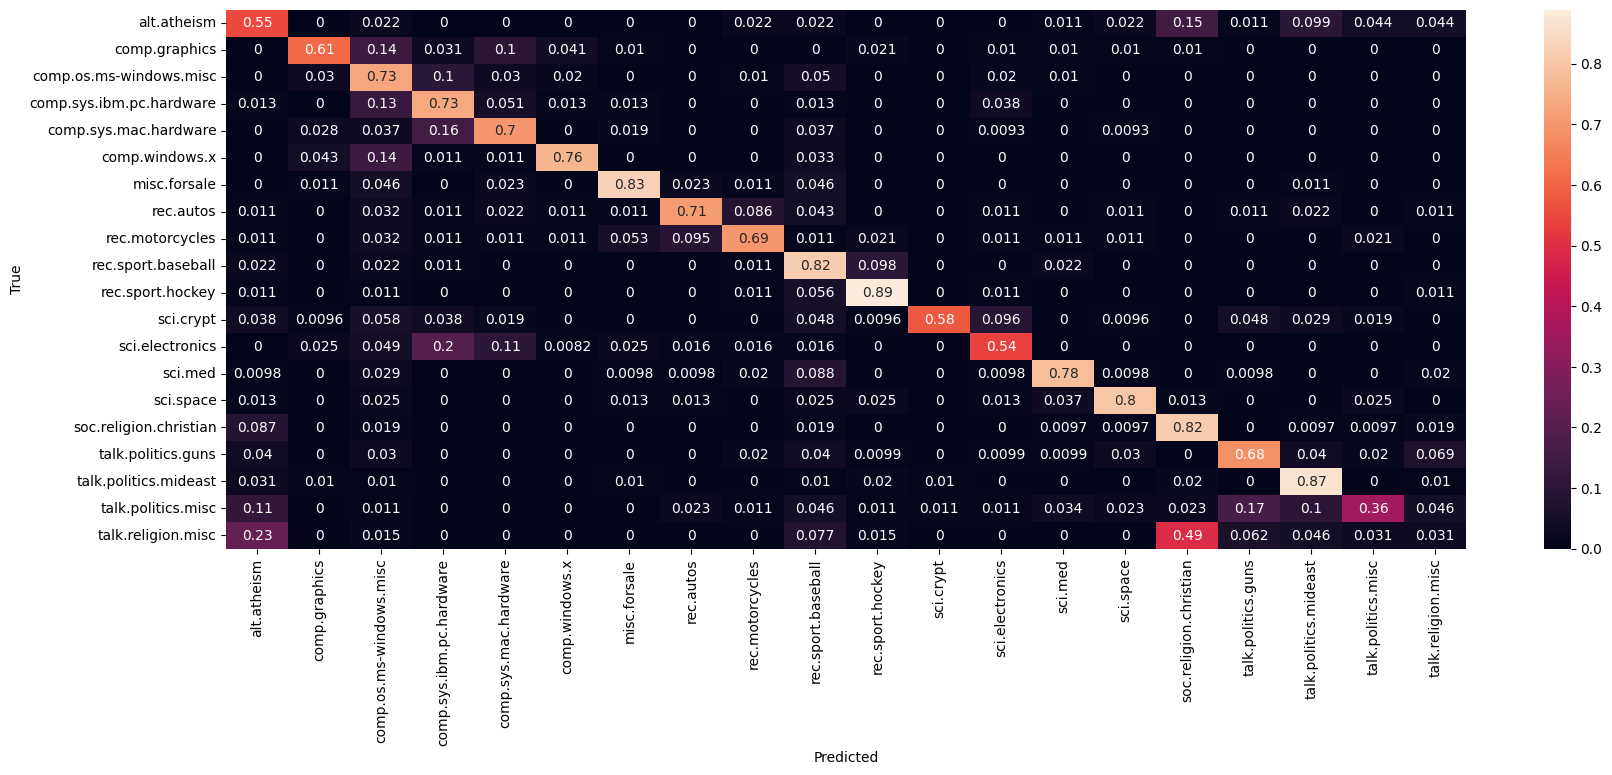

In [26]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### 3. Classification using two stages

Okay, not bad.  As you can see, some categories are easier to distinguish than others. Look for the class with the lowest F1 score (it should be the one at the bottom of the list). In the confusion matrix, which other class is that one being mistaken for most often?

You might notice that the categories in this dataset are somewhat heirarchical. There are more obvious differences between groups of news categories (e.g. computers vs recreation) and then subtler differences between categories within those groups (e.g. PC vs Mac, within computers).

When this happens, one idea is to train a series of models, to first separate out the more obvious groups of classes, and then use more specialized sub-models to classify only a subset of the classes. Let's try that here.

#### Step 1: New model with 19 classes

For simplicity, we'll just combine two categories in our first step. We'll replace the label of the last class with the label of the class it's most often mistaken for. (That way, we'll have labels from 0 to 18 instead of 0 to 19, and don't have to renumber everything, though you would have to if you group them more.)

In [ ]:
print(target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [41]:
# label_to_replace_with = ...
### YOUR CODE HERE

label_to_replace = 19 #the last class: 'talk.religion.misc'
label_to_replace_with = 15 #and it's most often mistaken for 'soc.religion.christian'


### END YOUR CODE

train_labels_19class = train_labels.copy()
train_labels_19class[train_labels_19class == label_to_replace] = label_to_replace_with

valid_labels_19class = npvalid_labels.copy()
valid_labels_19class[valid_labels_19class == label_to_replace] = label_to_replace_with

test_labels_19class = test_labels.copy()
test_labels_19class[test_labels_19class == label_to_replace] = label_to_replace_with

Now let's create a new model with the same architecture, but to predict probabilities for 19 classes instead of 20. We're using all of the data in this first step, so we'll use the encodings we already preprocessed as inputs, but use the new labels that only have 19 classes.

In [42]:
bert_model_19class = create_bert_multiclass_model(checkpoint = model_checkpoint, num_classes=19)

In [43]:
#Get the format of labels to one-hot-encoding
train_labels_19class_one_hot = pd.get_dummies(train_labels_19class).to_numpy()
valid_labels_19class_one_hot = pd.get_dummies(valid_labels_19class).to_numpy()
test_labels_19class_one_hot = pd.get_dummies(test_labels_19class).to_numpy()

In [44]:
bert_model_19class_history = bert_model_19class.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels_19class_one_hot,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                                   valid_labels_19class_one_hot),
                                                  batch_size=8,
                                                  epochs=1)

2000/2000 [==============================] - 777s 364ms/step - loss: 0.8102 - accuracy: 0.7806 - val_loss: 0.9170 - val_accuracy: 0.7430


In [45]:
#Evaluate the fine tuned 19-class model against the test data with 19-class labels
### YOUR CODE HERE

score = bert_model_19class.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels_19class_one_hot)
### END YOUR CODE
print('Test loss:', score[0])
print('Test accuracy:', score[1])

59/59 [==============================] - 26s 433ms/step - loss: 0.9769 - accuracy: 0.7294
Test loss: 0.9768890738487244
Test accuracy: 0.7294429540634155


**QUESTION:**

3.1 What is the test accuracy you get when you run the new first stage model with only 19 classes?  0.72944


In [46]:
#run and capture all the predictions from the 19 class data
### YOUR CODE HERE

predictions_19class = bert_model_19class.predict([test_encodings.input_ids[:], test_encodings.token_type_ids[:], test_encodings.attention_mask[:]])
predictions_19class = tf.argmax(predictions_19class, axis=-1)
### END YOUR CODE

predictions_19class

59/59 [==============================] - 28s 425ms/step


<tf.Tensor: shape=(1885,), dtype=int64, numpy=array([14, 18, 12, ..., 13,  4, 17])>

In [47]:
print(test_labels_19class.shape)
print(predictions_19class.numpy().shape)
print(test_labels.shape)
print(predictions_model1.numpy().shape)

(1885,)
(1885,)
(1885,)
(1885,)


In [58]:
#combine class = soc.religion.christian(15) + alk.politics.misc(19)
target_names_19class = target_names[:label_to_replace_with] \
                     + ['** COMBINED CLASS **'] \
                     + target_names[label_to_replace_with+1:19]

print(classification_report(test_labels_19class, predictions_19class.numpy(),
                            target_names=target_names_19class))

                          precision    recall  f1-score   support

             alt.atheism       0.63      0.65      0.64        91
           comp.graphics       0.79      0.65      0.71        97
 comp.os.ms-windows.misc       0.81      0.59      0.68       100
comp.sys.ibm.pc.hardware       0.61      0.52      0.56        79
   comp.sys.mac.hardware       0.73      0.72      0.72       107
          comp.windows.x       0.71      0.83      0.76        92
            misc.forsale       0.81      0.84      0.82        87
               rec.autos       0.76      0.76      0.76        93
         rec.motorcycles       0.81      0.73      0.77        95
      rec.sport.baseball       0.85      0.85      0.85        92
        rec.sport.hockey       0.90      0.91      0.91        90
               sci.crypt       0.88      0.65      0.75       104
         sci.electronics       0.77      0.65      0.71       122
                 sci.med       0.82      0.81      0.82       102
         

**QUESTION:**

3.2 What is the F1 score you get for the combined class when you run the new first stage model with only 19 classes? 0.74


#### Step 2: New model with only the two classes combined in step one

Now, our first stage model is able to determine which text is one of the two often confused classes, but we need to train a more specific model to distinguish between just these two classes. Ideally, this model will only focus on the more subtle differences between these two news categories, since it doesn't have to learn everything else about the other categories.

For this model, we're only going to train using the text examples that are one of the two confused categories. We'll keep the encodings we already tokenized, so we need to separate out the input_ids, token_type_ids, and attention_mask for just the rows that have one of these two labels.

In [49]:
#19s are replaced with 0
#label_to_replace_with = 15, so there is only 15 left (including original 19, but now labeled as 15 as well)
#inputs were filtered out to 15
#labels are filtered out to whether it's 'soc.religion.christian' or not ('talk.religion.misc')
train_mask_2class = (train_labels_19class == label_to_replace_with) #15 and 19
train_encodings_2class = {'input_ids': train_encodings.input_ids[train_mask_2class],
                          'token_type_ids': train_encodings.token_type_ids[train_mask_2class],
                          'attention_mask': train_encodings.attention_mask[train_mask_2class]}
train_labels_2class = train_labels.copy()[train_mask_2class] #15 and 19
train_labels_2class = (train_labels_2class == label_to_replace_with).astype(int) #15 -> 1

valid_mask_2class = (valid_labels_19class == label_to_replace_with)
valid_encodings_2class = {'input_ids': valid_encodings.input_ids[valid_mask_2class],
                          'token_type_ids': valid_encodings.token_type_ids[valid_mask_2class],
                          'attention_mask': valid_encodings.attention_mask[valid_mask_2class]}
valid_labels_2class = npvalid_labels.copy()[valid_mask_2class]
valid_labels_2class = (valid_labels_2class == label_to_replace_with).astype(int)

test_mask_2class = (test_labels_19class == label_to_replace_with)
test_encodings_2class = {'input_ids': test_encodings.input_ids[test_mask_2class],
                          'token_type_ids': test_encodings.token_type_ids[test_mask_2class],
                          'attention_mask': test_encodings.attention_mask[test_mask_2class]}
test_labels_2class = test_labels.copy()[test_mask_2class]
test_labels_2class = (test_labels_2class == label_to_replace_with).astype(int)

In [50]:
train_labels_2class.shape

(1370,)

In [51]:
train_labels_2class

array([0, 0, 0, ..., 0, 0, 1])

Create and train a new model with the same architecture as before, except that it only predicts two classes. (Note that we could change this to a binary prediction model, but we'll keep it multiclass for consistency here.)

In [52]:
bert_model_2class = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=2)

In [53]:
#Get the format of labels to one-hot-encoding
train_mask_2class_one_hot = pd.get_dummies(train_labels_2class).to_numpy()
valid_labels_2class_one_hot = pd.get_dummies(valid_labels_2class).to_numpy()
test_labels_2class_one_hot = pd.get_dummies(test_labels_2class).to_numpy()

In [54]:
bert_model_2class_history = bert_model_2class.fit([train_encodings_2class['input_ids'],
                                                   train_encodings_2class['token_type_ids'],
                                                   train_encodings_2class['attention_mask']],
                                                  train_mask_2class_one_hot,
                                                  validation_data=([valid_encodings_2class['input_ids'],
                                                                    valid_encodings_2class['token_type_ids'],
                                                                    valid_encodings_2class['attention_mask']],
                                                                   valid_labels_2class_one_hot),
                                                  batch_size=8,
                                                  epochs=1)

172/172 [==============================] - 127s 453ms/step - loss: 0.5246 - accuracy: 0.7504 - val_loss: 0.4429 - val_accuracy: 0.7701


In [55]:
#Evaluate the two-class model against the two-class test set.
### YOUR CODE HERE

score = bert_model_2class.evaluate([test_encodings_2class['input_ids'], test_encodings_2class['token_type_ids'], test_encodings_2class['attention_mask']],
                                                  test_labels_2class_one_hot)
### END YOUR CODE
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 2s 372ms/step - loss: 0.5621 - accuracy: 0.7143
Test loss: 0.5620839595794678
Test accuracy: 0.7142857313156128


In [56]:
#run and capture all the predictions from the 2-class test data
### YOUR CODE HERE

predictions_2class = bert_model_2class.predict([test_encodings_2class['input_ids'][:], test_encodings_2class['token_type_ids'][:], test_encodings_2class['attention_mask'][:]])
predictions_2class = tf.argmax(predictions_2class, axis=-1)

### END YOUR CODE
predictions_2class

6/6 [==============================] - 7s 372ms/step


<tf.Tensor: shape=(168,), dtype=int64, numpy=
array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0])>

In [57]:
# Run the sklearn classification_report again with the 2-class predictions
### YOUR CODE HERE

target_names_2class = ['soc.religion.christian', 'talk.religion.misc']
print(classification_report(test_labels_2class, predictions_2class.numpy(), target_names=target_names_2class))

### END YOUR CODE

                        precision    recall  f1-score   support

soc.religion.christian       0.61      0.74      0.67        65
    talk.religion.misc       0.81      0.70      0.75       103

              accuracy                           0.71       168
             macro avg       0.71      0.72      0.71       168
          weighted avg       0.73      0.71      0.72       168



**QUESTION:**

3.3 What is the macro average F1 score you get when you run the new second stage model with only 2 classes? 0.71

#### Step 3: Combine the predicted labels from the two steps

To combine our models into two steps, start with the predictions from the first step. Keep all predicted labels except the ones with a predicted value of label_to_replace_with (the label we gave to both of the confused classes in the first step).

Wherever the first model predicted the combined category, we'll replace the predictions with the label from the second model. If we used these models in inference, we'd only send an example to the second model if the first model predicted that it was from the combined class.

In [59]:
#if prediction result of 19 class = 0 then apply the result of the 2 class model


# Now get the examples that the first model predicted as in the combined class
test_mask_2class = (predictions_19class.numpy() == label_to_replace_with)
test_encodings_2class = {'input_ids': test_encodings.input_ids[test_mask_2class],
                         'token_type_ids': test_encodings.token_type_ids[test_mask_2class],
                         'attention_mask': test_encodings.attention_mask[test_mask_2class]}

# Run those examples through the step 2 model and save the predictions
predictions_2class = bert_model_2class.predict([test_encodings_2class['input_ids'],
                                                test_encodings_2class['token_type_ids'],
                                                test_encodings_2class['attention_mask']],)
predictions_2class = tf.argmax(predictions_2class, axis=-1)

# Replace the step 2 model's predicted labels with the original values from the 20-class dataset
#label_to_replace = 19, label_to_replace_with = 0
predictions_2class = predictions_2class.numpy()
predictions_2class[predictions_2class == 0] = label_to_replace
predictions_2class[predictions_2class == 1] = label_to_replace_with

# Combine the labels from both steps for the full test dataset
predictions_2steps = predictions_19class.numpy()
predictions_2steps[test_mask_2class] = predictions_2class

predictions_2steps

5/5 [==============================] - 2s 390ms/step


array([14, 18, 12, ..., 13,  4, 17])

Now let's look at the classification report and confusion matrix, using the combined predictions from our two step model (compared to the original labels). Did the overall results get better?

In [60]:
print(predictions_2steps.shape)
print(test_labels.shape)

(1885,)
(1885,)


In [61]:
# Run the sklearn classification_report with all 20 classes from the 2-step predictions
### YOUR CODE HERE

print(classification_report(test_labels, predictions_2steps, target_names=target_names))

### END YOUR CODE

                          precision    recall  f1-score   support

             alt.atheism       0.63      0.65      0.64        91
           comp.graphics       0.79      0.65      0.71        97
 comp.os.ms-windows.misc       0.81      0.59      0.68       100
comp.sys.ibm.pc.hardware       0.61      0.52      0.56        79
   comp.sys.mac.hardware       0.73      0.72      0.72       107
          comp.windows.x       0.71      0.83      0.76        92
            misc.forsale       0.81      0.84      0.82        87
               rec.autos       0.76      0.76      0.76        93
         rec.motorcycles       0.81      0.73      0.77        95
      rec.sport.baseball       0.85      0.85      0.85        92
        rec.sport.hockey       0.90      0.91      0.91        90
               sci.crypt       0.88      0.65      0.75       104
         sci.electronics       0.77      0.65      0.71       122
                 sci.med       0.82      0.81      0.82       102
         

In [62]:
cm = tf.math.confusion_matrix(test_labels, predictions_2steps)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

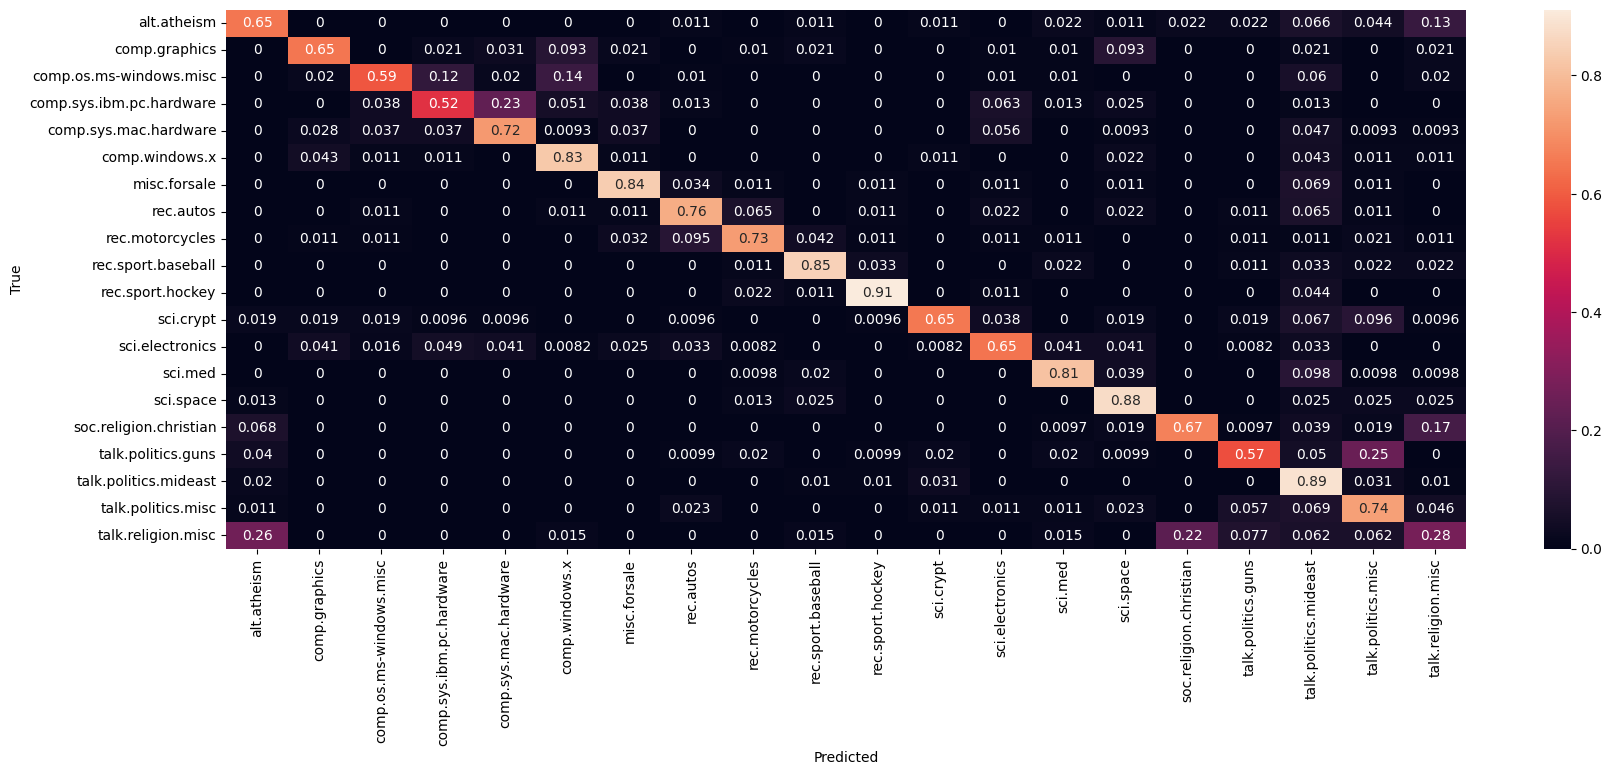

In [63]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

**QUESTION:**

3.4 What is the macro average F1 score you get from the combined two-step model? 0.71

3.5 What is the difference in points between the macro weighted F1 score for the original model and the combined two-step model?

>> The macro weighted F1 score of original model is 0.68 and of the combined two-step model is 0.71. The difference in points is 0.03.

3.6 What is the new F1 score for the last category (i.e. label_to_replace, the one that had the lowest F1 score in the original model)? 0.28

3.7 What is the new F1 score for the other category that you combined with the last category in the two-step model (i.e. label_to_replace_with)? 0.73

3.8 Which metric (precision or recall) is now lower for the other category (i.e. label_to_replace_with)?

>> Recall, the recall of 'sco.religion.christian' drops from 0.82 of original model to 0.67 of two steps model

### Look at examples of misclassifications

What happened in the two-step model? Did everything improve, or did something get worse? We were concerned about the last news category, which had a very low F1 score in the original model. In the two-step model, the F1 score for that category should have gone up.

But for the other category that the original model often confused with the last category, the F1 score might have gone down. In particular, one of the two component metrics, precision or recall, probably went down. (We ask you which one went down in question 3.7 above.)

We might be able to tell what happened from the confusion matrix, but it's also always a good idea to look at actual examples that were misclassified, to see if we can spot any patterns. We can also isolate more specific examples, like test examples that the original model got right, but the two-step model got wrong. Let's do that below.

**CRITICAL NOTE:**  If nothing prints out when you run the code below, there are two possibilities.  The first is that there is some error in the code or variable names you have created in earlier cells.  The second possibility is that given your current train, validation, and test split, the second model predicted the "label_to_replace_with" class and the first model did so too.  This is unlikely but it is possible. In either case, you must go back and re-run the *ENTIRE* notebook to make sure you get a new train, validation, and test split which will allow you to observe the first and second models disagreeing. Please make sure you enter the metric values from this new run into your answers file.

In [102]:
# Make a vector the length of our test set, with 1 if the second model predicted the
# "label_to_replace_with" class, and 0s otherwise
select_predictions = (predictions_2steps == label_to_replace_with)


In [103]:
# Now only keep a 1 if that was not the correct label, i.e. it was a false positive
select_predictions = select_predictions * (test_labels != label_to_replace_with)

In [104]:
# And now only keep a 1 if the original model predicted the correct label instead
select_predictions = select_predictions * (test_labels == predictions_model1.numpy())

In [105]:
# Print out the original and clean text of the examples that met the above conditions
for i in np.where(select_predictions)[0]:

    print('Prediction: model1 = %s, model2 = %s):\nText: %s\n\n' %
          (target_names[predictions_model1[i]],
           target_names[predictions_2steps[i]],
           test_texts[i][:1000].replace('\n', ' ')))

#orignal model is right but two steps is wrong

Prediction: model1 = talk.religion.misc, model2 = soc.religion.christian):
Text:  I agree, which is why I've asked for help with it.  The reason I'm working on this list is because I've recently had one too many Christians tell me "the Bible contains no contradictions whatsoever."  They believe that it's true, and that it describes reality perfectly, and even predicts history before it happens.  Before I can carry on any sort of meaningful conversation with these people, I've got to SHOW them, with concrete evidence, that the Bible is not nearly as airtight as they thought.  I hope to do that with this list.  Specifically: when I bring up the fact that Genesis contains two contradictory creation stories, I usually get blank stares or flat denials.  I've never had a fundamentalist acknowledge that there are indeed two different accounts of creation. 


Prediction: model1 = talk.religion.misc, model2 = soc.religion.christian):
Text:   Yes, this is certainly one of the traditional ideas a

**QUESTION:**

4.1 Why do you think the two-step model got these examples wrong, when the original model got them right? C

- A. The two-step model saw less examples of the "label_to_replace" class, because we replaced them with the "label_to_replace_with" examples. So it didn't learn the kind of text in that class as well as the original model.

>> the training data remains the same, we didn't delete any of the data

- B. In the two-step process, the step 1 model overpredicted the combined class, and the step 2 model overpredicted the "label_to_replace_with" class. A third class is now getting mistaken more often for the "label_to_replace_with" class, than in the original model.

>> there is no third class getting mistaken

- C. It's probably just random that the original model got these specific examples right and the two-step model got them wrong.

>> It may be the 2 steps model capture some key words related to christian like 'Christians ' in the first example and 'Catholicism ' in the second example



4.2 Is there anything you might try next, to try to make the two-step model better? C

- A. Try to balance the training data across classes at each step, or add class weights when calling model.fit.

>> yes, 'talk.religion.misc' has fewest amount of data, only 65.

- B. Try to combine another similar category with the two easily confused ones, for a step 1 model with 18 classes and the step 2 model with 3 classes.

>>may work, in the original model 'talk.religion.misc' the most confused category has 0.49 proportion (soc.religion.christian) and the second gets 0.23 ('alt.atheism')

- C. Try both A and B